# Kuramoto-Sivashinsky Quasiperiodic Circular Coordinates

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.io as sio
from scipy import sparse 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
from persim import plot_diagrams, wasserstein
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from gtda.diagrams import PairwiseDistance # For Bottleneck / Wasserstein
from dreimac import CircularCoords
import os
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load in full resolution data and subsample by a factor of 10

In [2]:
def plot_data(locs, X):
    plt.figure(figsize=(10, 5))
    ylim = [np.min(X), np.max(X)]
    rg = ylim[1] - ylim[0]
    ylim = [ylim[0] - 0.1*rg, ylim[1] + 0.1*rg]
    for i in range(X.shape[0]):
        plt.clf()
        plt.plot(locs[i, :], X[i, :])
        plt.ylim(ylim)
        plt.xlim([0, 1])
        plt.savefig("KSFrames/{}.png".format(i), bbox_inches='tight')

In [3]:
def get_random_samples(X, n_samples):
    """
    Sample every time series with samples chosen uniformly at
    random and sorted
    
    Parameters
    ----------
    X: ndarray(N, T)
        N time series, each of length T
    n_samples: int
        Number of samples to take in each time series
    
    Returns
    -------
    locs: ndarray(N, n_samples)
        Sample locations for each time series on the interval [0, 1]
    Y: ndarray(N, n_samples)
        Samples
    """
    Y = np.zeros((X.shape[0], n_samples))
    locs = np.random.rand(X.shape[0], n_samples)
    locs = np.sort(locs, axis=1)
    idx = np.linspace(0, 1, X.shape[1])
    for i in range(X.shape[0]):
        Y[i, :] = np.interp(locs[i, :], idx, X[i, :])
    return locs, Y

In [348]:
res['x'].shape

(451, 451)

(500, 100)


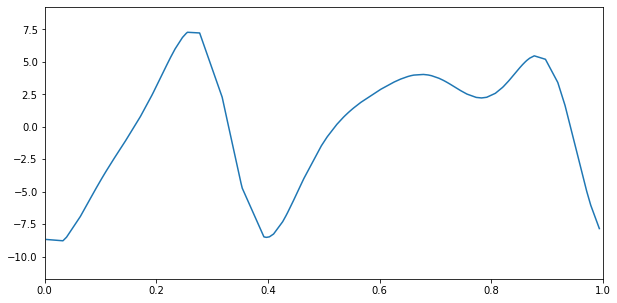

In [4]:
np.random.seed(0)
res = sio.loadmat("KSData/Kuramoto/KS_1_2_0_002.mat")
locs, X = get_random_samples(res['data'], 100)
#plot_data(locs, X)
print(X.shape)

In [10]:
def sliding_csm(D, win):
    """
    Perform the effect of a sliding window on an CSM by averaging
    along diagonals
    Parameters
    ----------
    D: ndarray(M, N)
        A cross-similarity matrix
    win: int
        Window length
    """
    M = D.shape[0] - win + 1
    N = D.shape[1] - win + 1
    S = np.zeros((M, N))
    J, I = np.meshgrid(np.arange(N), np.arange(M))
    for i in range(-M+1, N):
        x = np.diag(D, i)
        x = np.array([0] + x.tolist())
        x = np.cumsum(x)
        x = x[win::] - x[0:-win]
        S[np.diag(I, i), np.diag(J, i)] = x
    return S

In [11]:
def do_sublevelset_filtration(x):
    """
    Do a sublevelset filtration of a time series using an interval graph
    
    Parameters
    ----------
    x: ndarray(N)
        The time series
    
    Returns
    -------
    dgm: 0D persistence diagram, excluding the essential class
    """
    N = x.size
    # Add edges between adjacent points in the time series, with the "distance" 
    # along the edge equal to the max value of the points it connects
    I = np.arange(N-1)
    J = np.arange(1, N)
    I, J = np.concatenate((I, J)), np.concatenate((J, I))
    V = np.maximum(x[I], x[J])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    dgm = ripser(D, distance_matrix=True, maxdim=0)['dgms'][0]
    return dgm[np.isfinite(dgm[:, 1]), :]

def do_sublevelset_filtration_circular(x):
    """
    Do a sublevelset filtration of a time series, assuming it's on
    a periodic domain
    
    Parameters
    ----------
    x: ndarray(N)
        The time series
    
    Returns
    -------
    dgm: 0D persistence diagram, excluding the essential class
    """
    N = x.size
    # Add edges between adjacent points in the time series   
    I = np.concatenate((np.arange(N), np.arange(N)))
    J = np.concatenate(((np.arange(N)-1)%N, (np.arange(N)+1)%N))
    V = np.maximum(x[I], x[J])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    dgm = ripser(D, distance_matrix=True, maxdim=0)['dgms'][0]
    return dgm[np.isfinite(dgm[:, 1]), :]

## Example Sublevelset Filtration w/wo Circular



Interval
[[-0.6789754  -0.49045467]
 [ 2.36077189  2.88063383]
 [-3.51018143  5.5085597 ]
 [-7.44147635  7.15805483]]
Circular
[[-0.6789754  -0.49045467]
 [ 2.36077189  2.88063383]
 [-7.44147635  5.5085597 ]]


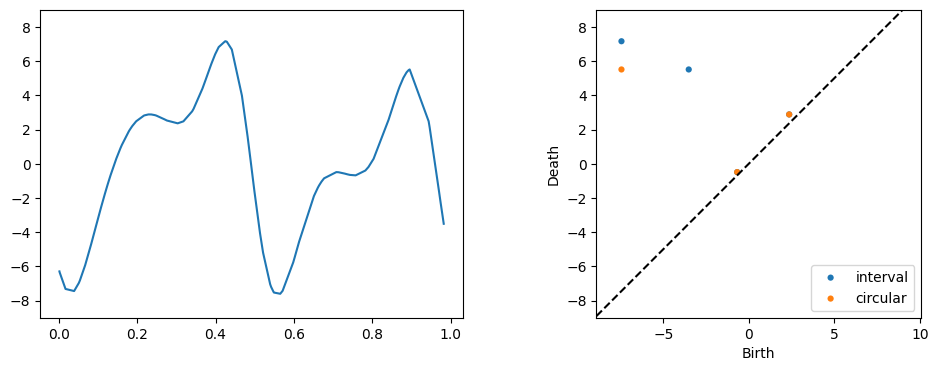

In [12]:
x = X[70, :]
loc = locs[70, :]
dgm1 = do_sublevelset_filtration(x)
dgm2 = do_sublevelset_filtration_circular(x)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(loc, x)
plt.ylim([-9, 9])
plt.subplot(122)
plot_diagrams([dgm1, dgm2], labels=['interval', 'circular'])
plt.ylim([-9, 9])
print("Interval")
print(dgm1)
print("Circular")
print(dgm2)

# All Pairwise Bottleneck / Wasserstein

First, compute all sublevelset filtrations using both the circular and interval methods

In [13]:
def get_dgms(X, sublevelset_fn):
    """
    Compute the 0D sublevelset filtrations for all of the time series in X
    
    Parameters
    ----------
    X: ndarray(N, T)
        N time series of length T
    sublevelset_fn: x->dgm
        A function for computing a sublevelset filtration of a time series
    
    Returns
    -------
    ndarray(N, max_persistence_points, 3)
        N persistence diagrams, in Giotto-TDA format
    """
    dgms_list = []
    max_len = 0
    for i in range(X.shape[0]):
        dgm = sublevelset_fn(X[i, :])
        dgms_list.append(dgm)
        max_len = max(max_len, dgm.shape[0])
    dgms = np.zeros((X.shape[0], max_len, 3))
    for i, dgm in enumerate(dgms_list):
        dgms[i, 0:dgm.shape[0], 0:2] = dgm
    return dgms

dgms_interval = get_dgms(X, do_sublevelset_filtration)
dgms_circular = get_dgms(X, do_sublevelset_filtration_circular)

Now, compute all pairwise Bottleneck And Wasserstein distances

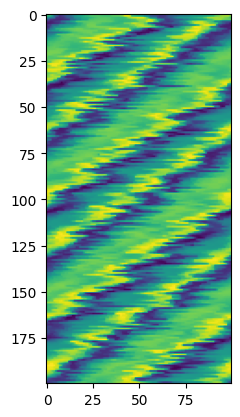

In [244]:
plt.imshow(X[:200,:])

Interval_bottleneck
Circle_bottleneck
Interval_wasserstein
Circle_wasserstein


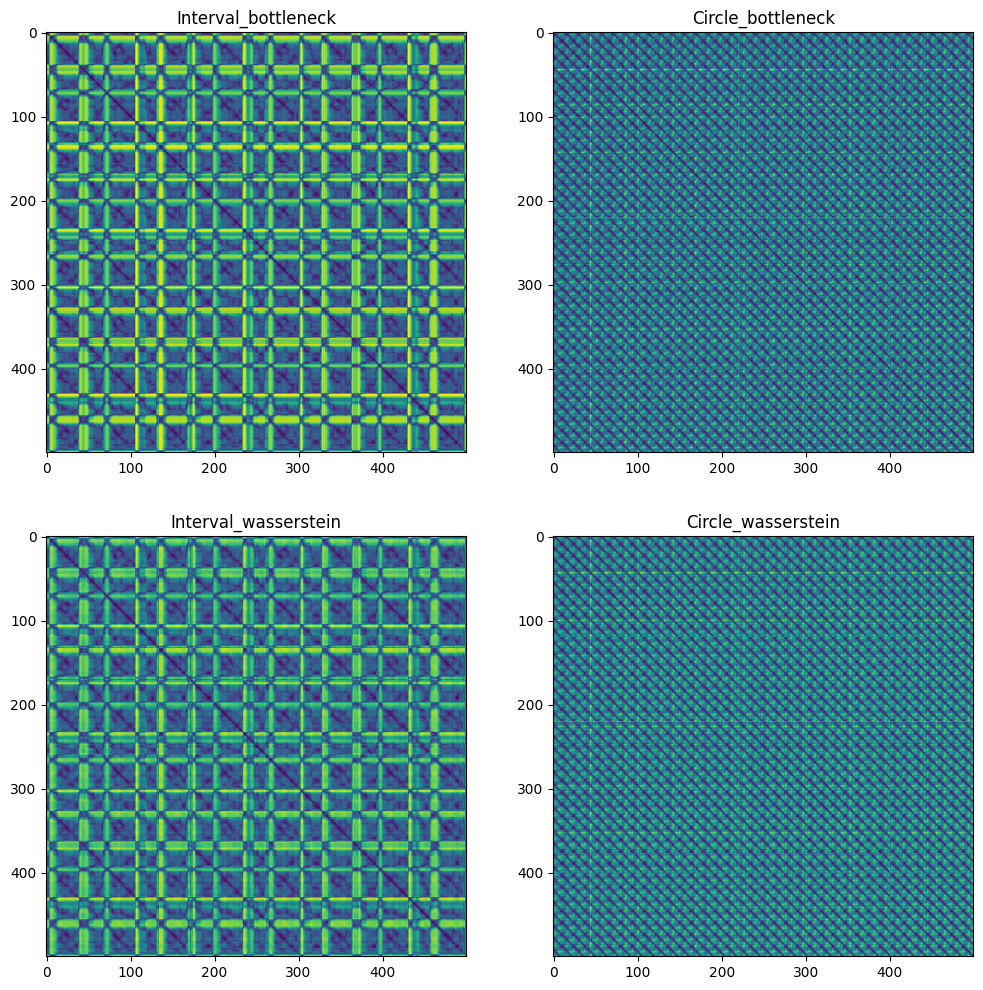

In [17]:
plt.figure(figsize=(12, 12))
k = 1
Ds = {}
for metric in ['bottleneck', 'wasserstein']:
    PD = PairwiseDistance(metric=metric, metric_params={'delta': 1e-5}, order=None)
    for dgms, dgms_title in zip((dgms_interval, dgms_circular), ['Interval', 'Circle']):
        key = "{}_{}".format(dgms_title, metric)
        print(key)
        D = PD.fit_transform(dgms)
        plt.subplot(2, 2, k)
        plt.imshow(D[:,:,0])
        plt.title(key)
        Ds[key] = np.reshape(D, (D.shape[0], D.shape[1]))
        k += 1

(500, 500)
(500, 500)
(500, 500)
(500, 500)


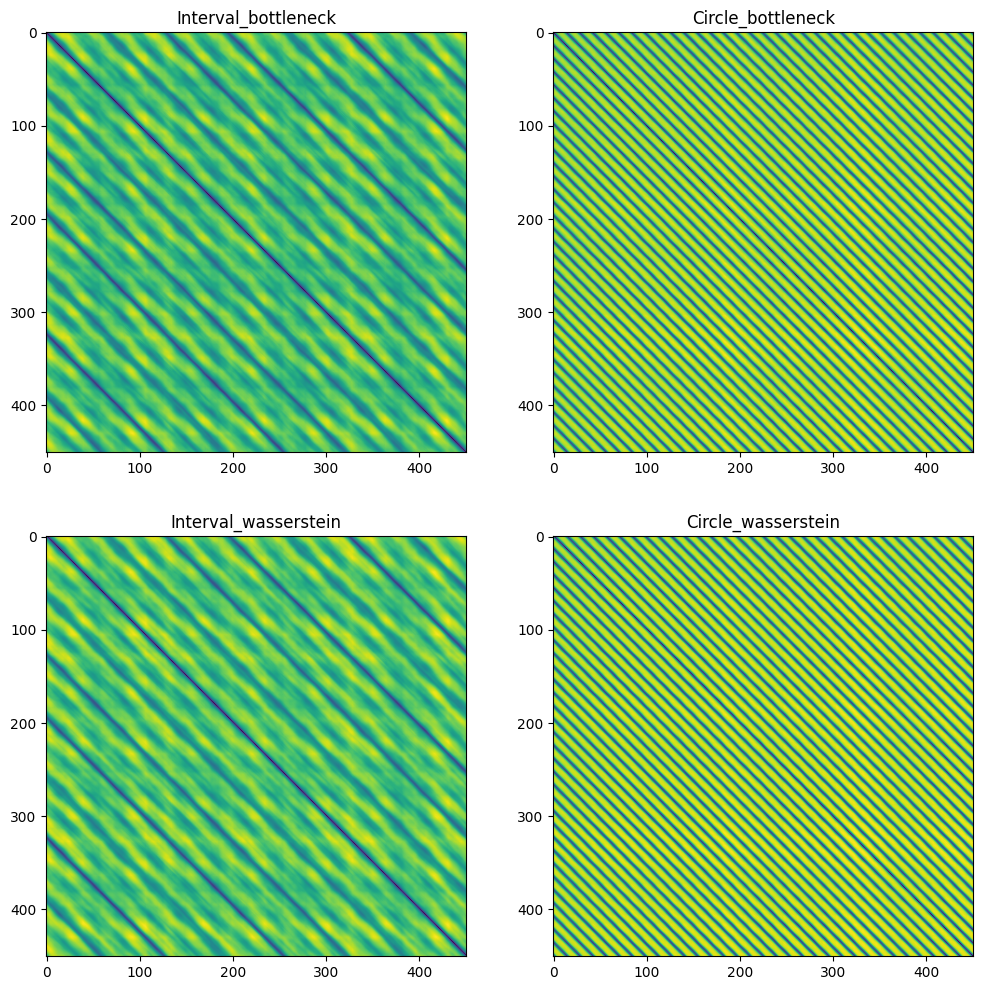

In [18]:
plt.figure(figsize=(12, 12))
k = 1
for metric in ['bottleneck', 'wasserstein']:
    for dgms_title in ['Interval', 'Circle']:
        key = "{}_{}".format(dgms_title, metric)
        D = Ds[key]
        print(D.shape)
        S = sliding_csm(D, 50)
        plt.subplot(2, 2, k)
        plt.imshow(S)
        plt.title(key)
        k += 1

Finally, perform circular coordinates

In [20]:
import scipy.io as sio
S = sliding_csm(Ds['Circle_wasserstein'], 50)
res = {'x':S}
sio.savemat("KSData/circle_wasserstein_sw.mat", res)

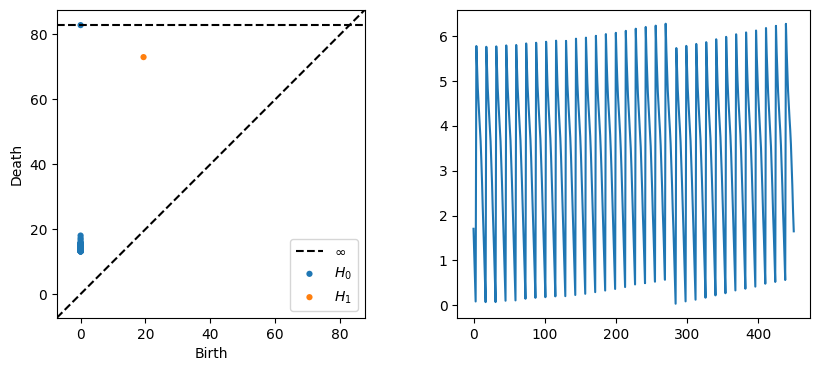

In [30]:
#S = sliding_csm(Ds['Circle_wasserstein'], 50)
cc = CircularCoords(S, 100, distance_matrix=True)
#thetas = cc.get_coordinates(perc=0.9, cocycle_idx=[0])
thetas = sio.loadmat("KSData/thetas.mat")['thetas']
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_diagrams(cc.dgms_)
plt.subplot(122)
plt.plot(np.arange(len(thetas[0])),thetas[0])

In [269]:
cc.dgms_[0]

array([[ 0.        , 13.09155655],
       [ 0.        , 13.11969471],
       [ 0.        , 13.14529896],
       [ 0.        , 13.16735554],
       [ 0.        , 13.18112755],
       [ 0.        , 13.20243454],
       [ 0.        , 13.21632004],
       [ 0.        , 13.27548409],
       [ 0.        , 13.33490086],
       [ 0.        , 13.36347771],
       [ 0.        , 13.40047264],
       [ 0.        , 13.43570328],
       [ 0.        , 13.45330143],
       [ 0.        , 13.46818161],
       [ 0.        , 13.46898651],
       [ 0.        , 13.47650719],
       [ 0.        , 13.48288918],
       [ 0.        , 13.48862171],
       [ 0.        , 13.49108887],
       [ 0.        , 13.51839733],
       [ 0.        , 13.52191544],
       [ 0.        , 13.54044151],
       [ 0.        , 13.5454607 ],
       [ 0.        , 13.69368076],
       [ 0.        , 13.71453762],
       [ 0.        , 13.74172974],
       [ 0.        , 13.74227238],
       [ 0.        , 13.74864101],
       [ 0.        ,

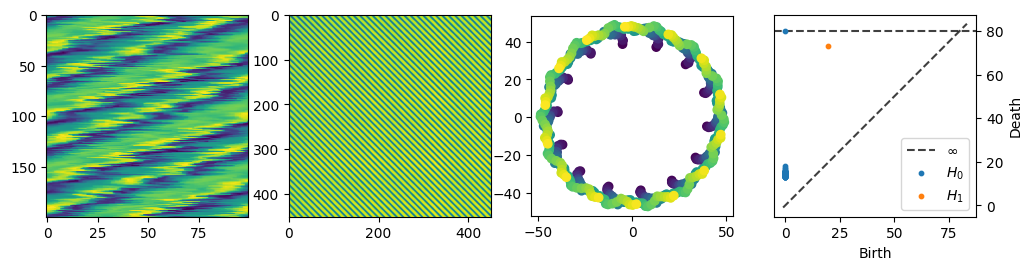

In [274]:
fig, (ax1,ax2,ax4,ax3) = plt.subplots(1,4,figsize = (12,3))
ax1.imshow(X[:200,:], aspect = 0.5)
ax2.imshow(S)

ax3.axhline(y = 80., linestyle = '--', c = 'black', alpha = 0.75, zorder=0, label = '$\infty$')
ph0 = cc.dgms_[0]
ph0[ph0 == np.inf] = 80.
ax3.scatter(ph0[:,0],ph0[:,1], label = '$H_0$', s = 10)
ax3.scatter(cc.dgms_[1][:,0],cc.dgms_[1][:,1], label = '$H_1$', s = 10)
#ax3.set_title('1-D Homology of Sliding Window Point Cloud')
ax3.legend(loc = 4)
ax3.set_aspect('equal','box')
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]

ax3.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

# now plot both limits against eachother
ax3.set_ylabel('Death')
ax3.set_xlabel('Birth')
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(S)

ax4.scatter(X_transformed[:,0],X_transformed[:,1],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.viridis)

ax4.set_aspect('equal','box')

plt.savefig('KS1D_results.png')

# Examining Fibers

Now let's pull out groups of time series that lie in a similar range

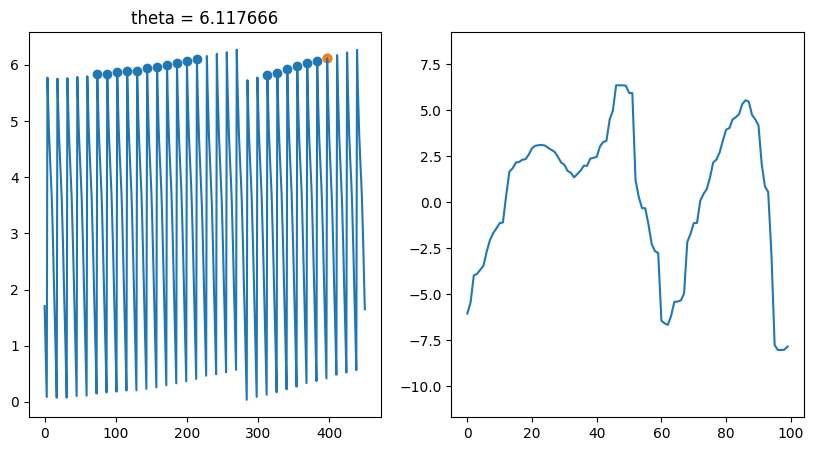

In [37]:
plt.figure(figsize=(10, 5))
ylim = [np.min(X), np.max(X)]
rg = ylim[1] - ylim[0]
ylim = [ylim[0] - 0.1*rg, ylim[1] + 0.1*rg]

thetas = thetas[0]

n_intervals = 20
dtheta = np.pi/n_intervals
for interval, theta in enumerate(np.linspace(0, 2*np.pi, n_intervals+1)[0:n_intervals]):
    fdir = "KSFibers/{}".format(interval)
    if not os.path.exists(fdir):
        os.mkdir(fdir)
    idxs = np.arange(thetas.size)
    discrep = np.abs(thetas-theta)
    discrep[discrep > np.pi] = 2*np.pi - discrep[discrep > np.pi]
    idxs = idxs[discrep < dtheta]
    for i, idx in enumerate(idxs):
        plt.clf()
        plt.subplot(121)
        plt.plot(np.arange(thetas.size), thetas)
        plt.scatter(idxs, thetas[idxs])
        plt.scatter([idx], [thetas[idx]])
        plt.title("theta = {:3f}".format(thetas[idx]))
        plt.subplot(122)
        plt.plot(X[idx, :])
        plt.ylim(ylim)
        plt.savefig("{}/{}.png".format(fdir, i))

## Analyze the Fiber

In [325]:
theta = 3.0
dtheta = 0.125

In [327]:
## Fiberwise analysis
idxs = np.arange(thetas.size)
discrep = np.abs(thetas-theta)
discrep[discrep > np.pi] = 2*np.pi - discrep[discrep > np.pi]
idxs = idxs[discrep < dtheta]
print(idxs)


[152 166 180 194 208 222 236 250 349 363 377 391 405 419]


In [337]:
samples = idxs
dists = np.zeros((len(samples),len(samples)))
for i in range(len(samples)):
    for j in range(len(samples)):
        dists[i,j] = np.sqrt(0.01*np.sum((X[idxs[i],:] - X[idxs[j],:])**2))
dists = dists + dists.T

In [338]:
#not even the SW dist matrix. Wait is it correct to use the SW distance matrix here?
sw = sliding_csm(dists, 1)
PDs = ripser(sw, distance_matrix=True, maxdim=1, coeff=3)['dgms']

from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(sw)
print(X_transformed.shape)

(14, 2)


Text(0.5, 0, 'x')

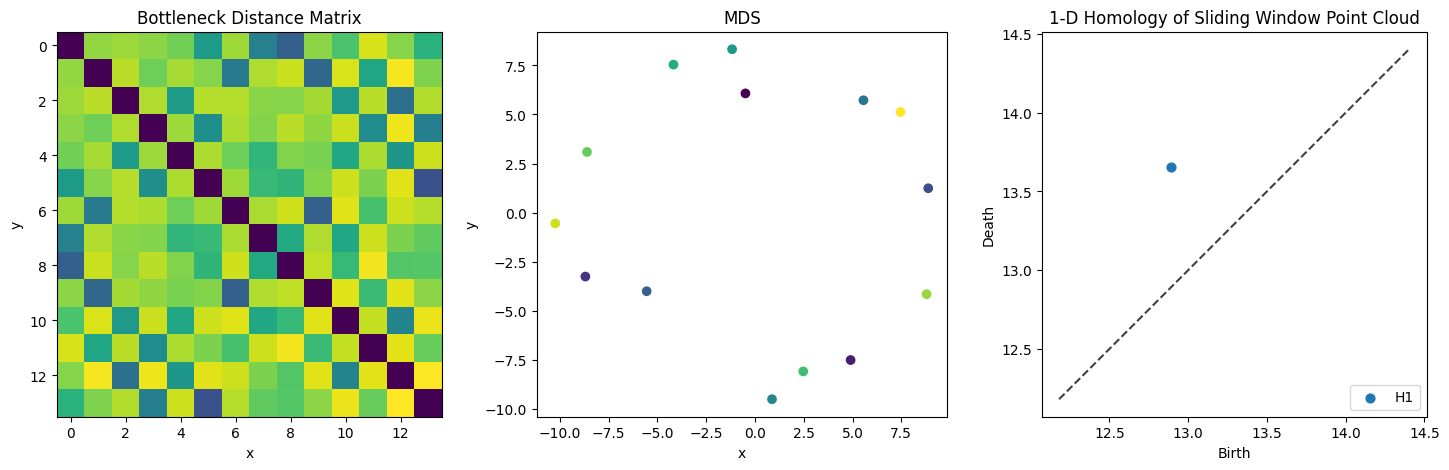

In [339]:
fig = plt.figure(figsize = (18,5))

ax2 = fig.add_subplot(133)
ax2.scatter(PDs[1][:,0],PDs[1][:,1],s = 40, label = 'H1')
ax2.set_title('1-D Homology of Sliding Window Point Cloud')
ax2.legend(loc = 4)
ax2.set_aspect('equal','box')
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

ax2.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

# now plot both limits against eachother
ax2.set_ylabel('Death')
ax2.set_xlabel('Birth')

ax3 = fig.add_subplot(131)
ax3.imshow(sw)
ax3.set_title('Bottleneck Distance Matrix')
ax3.set_ylabel('y')
ax3.set_xlabel('x')

ax4 = fig.add_subplot(132)
ax4.scatter(X_transformed[:,0],X_transformed[:,1],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.viridis)
ax4.set_title('MDS')
ax4.set_ylabel('y')
ax4.set_xlabel('x')

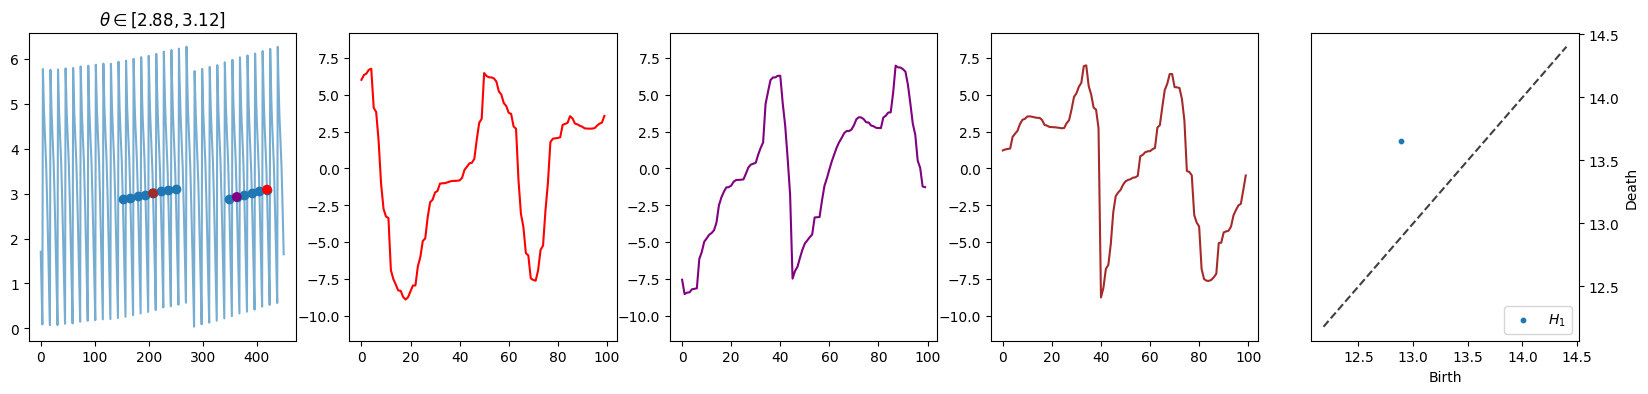

In [346]:
cs = ['red','purple','brown']

plt.figure(figsize = (20,4))
plt.subplot(151)
plt.plot(np.arange(thetas.size), thetas, alpha = 0.6)
plt.scatter(idxs, thetas[idxs])
plt.scatter([idxs[-1],idxs[-5],idxs[-10]],
            [thetas[idxs[-1]], thetas[idxs[-5]], thetas[idxs[-10]]],c = cs , zorder = 10)
plt.title(r'$ \theta \in [{:.2f},{:.2f}]$'.format(theta-dtheta,theta+dtheta))

plt.subplot(152)
plt.plot(X[idxs[-1], :],c = cs[0])
plt.ylim(ylim)

plt.subplot(153)
plt.plot(X[idxs[-5], :], c = cs[1])
plt.ylim(ylim)


plt.subplot(154)
plt.plot(X[idxs[-10], :], c = cs[2])
plt.ylim(ylim)

ax2 = plt.subplot(155)
ax2.scatter(PDs[1][:,0],PDs[1][:,1],s = 10, label = '$H_1$')
ax2.legend(loc = 4)
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

ax2.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

# now plot both limits against eachother
ax2.set_ylabel('Death')
ax2.set_xlabel('Birth')


plt.savefig("ks_circular_coordinates.png")